In [3]:
import gzip
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
path = "/home/nbatjargal/private/data"
def readGz(path):
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for l in f:
            if l.strip():  # skip empty lines
                yield ast.literal_eval(l)

In [5]:
rows = list(readGz(path + "/australian_user_reviews.json.gz"))
df = pd.DataFrame(rows)

df_expanded = df.explode("reviews", ignore_index=True)

df_reviews = (
    df_expanded
      .drop(columns=["reviews"])
      .join(pd.json_normalize(df_expanded["reviews"]))
)

df_reviews.head()


,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


In [6]:
rows = list(readGz(path + "/australian_users_items.json.gz"))
df = pd.DataFrame(rows)

df_expanded = df.explode("items", ignore_index=True)

df_items = (
    df_expanded
      .drop(columns=["items"])
      .join(pd.json_normalize(df_expanded["items"]))
)

df_items.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


In [7]:
rows = list(readGz(path + "/bundle_data.json.gz"))
df = pd.DataFrame(rows)

# Find which column is a list
list_col = df.applymap(lambda x: isinstance(x, list)).any()

list_col = list_col[list_col].index[0]   # first detected list-column name

df_expanded = df.explode(list_col, ignore_index=True)

df_bundles = (
    df_expanded
      .drop(columns=[list_col])
      .join(pd.json_normalize(df_expanded[list_col]))
)

df_bundles.head()

/tmp/ipykernel_5652/1942573490.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  list_col = df.applymap(lambda x: isinstance(x, list)).any()


,bundle_final_price,bundle_url,bundle_price,bundle_name,bundle_id,bundle_discount,genre,item_id,discounted_price,item_url,item_name
0,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%,"Adventure, Indie, RPG",326950,$8.99,http://store.steampowered.com/app/326950,Sword of Asumi
1,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%,"Adventure, Indie, RPG",331490,$2.99,http://store.steampowered.com/app/331490,Sword of Asumi - Soundtrack
2,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%,"Adventure, Indie, RPG",331491,$1.99,http://store.steampowered.com/app/331491,Sword of Asumi - Graphic Novel
3,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%,"Adventure, Indie, RPG",331492,$0.99,http://store.steampowered.com/app/331492,Sword of Asumi - Character Creator
4,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,10%,"Adventure, Casual, Indie",348540,$12.99,http://store.steampowered.com/app/348540,Divine Slice of Life


In [8]:
rows = list(readGz(path + "/steam_games.json.gz"))
df_games = pd.DataFrame(rows)

df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [9]:
print("df_reviews shape:", df_reviews.shape)
print("df_items shape:", df_items.shape)
print("df_bundles shape:", df_bundles.shape)
print("df_games shape:", df_games.shape)

df_reviews shape: (59333, 9)
df_items shape: (5170015, 8)
df_bundles shape: (3525, 11)
df_games shape: (32135, 16)


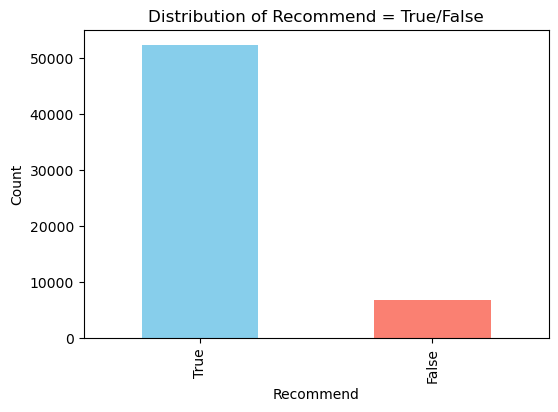

recommend
True     0.884799
False    0.115201
Name: proportion, dtype: float64


In [10]:
plt.figure(figsize=(6,4))
df_reviews['recommend'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Distribution of Recommend = True/False")
plt.xlabel("Recommend")
plt.ylabel("Count")
plt.show()

print(df_reviews['recommend'].value_counts(normalize=True))


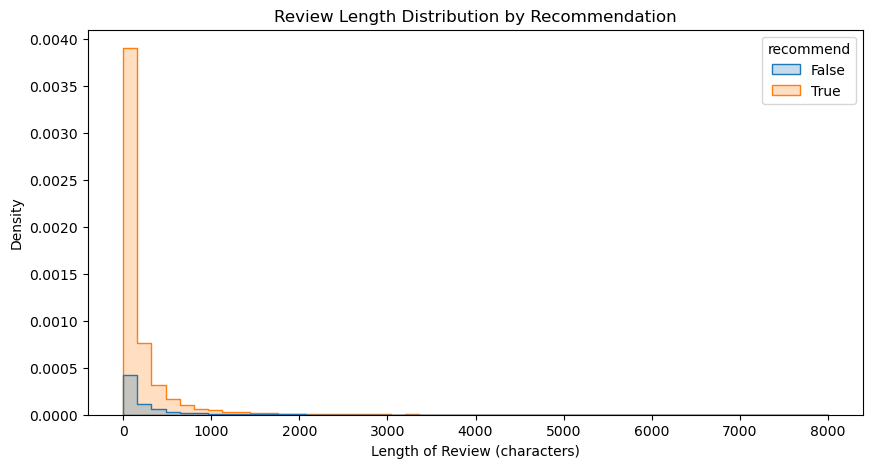

In [12]:
df_reviews['review_length'] = df_reviews['review'].fillna("").apply(len)

plt.figure(figsize=(10,5))
sns.histplot(
    data=df_reviews,
    x="review_length",
    hue="recommend",
    bins=50,
    element="step",   # makes overlapping clearer
    stat="density"
)
plt.title("Review Length Distribution by Recommendation")
plt.xlabel("Length of Review (characters)")
plt.show()

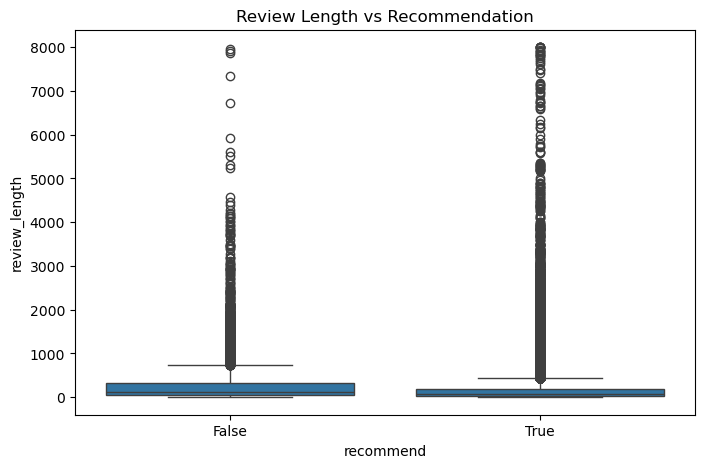

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(x='recommend', y='review_length', data=df_reviews)
plt.title("Review Length vs Recommendation")
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=30)
X = tfidf.fit_transform(df_reviews['review'].fillna(""))
words = tfidf.get_feature_names_out()

print("Top common words:")
print(words)


Top common words:
['10' 'amazing' 'awesome' 'bad' 'best' 'better' 'buy' 'don' 'fun' 'game'
 'gameplay' 'games' 'good' 'great' 'hours' 'just' 'like' 'love' 'make'
 'new' 'people' 'play' 'played' 'playing' 'que' 'really' 'recommend'
 'story' 'time' 'want']


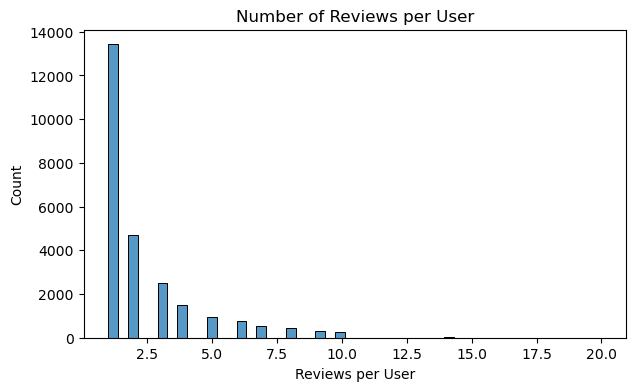

In [15]:
user_review_counts = df_reviews['user_id'].value_counts()

plt.figure(figsize=(7,4))
sns.histplot(user_review_counts, bins=50)
plt.title("Number of Reviews per User")
plt.xlabel("Reviews per User")
plt.show()

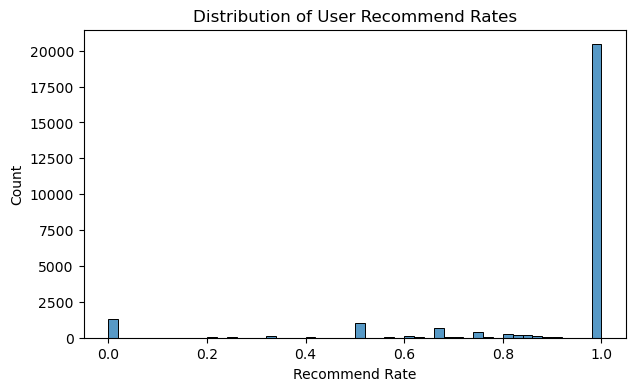

In [16]:
user_rec_rate = df_reviews.groupby('user_id')['recommend'].mean()

plt.figure(figsize=(7,4))
sns.histplot(user_rec_rate, bins=50)
plt.title("Distribution of User Recommend Rates")
plt.xlabel("Recommend Rate")
plt.show()

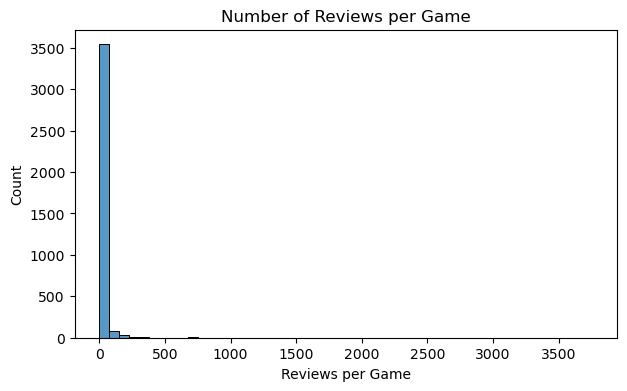

In [17]:
game_review_counts = df_reviews['item_id'].value_counts()

plt.figure(figsize=(7,4))
sns.histplot(game_review_counts, bins=50)
plt.title("Number of Reviews per Game")
plt.xlabel("Reviews per Game")
plt.show()

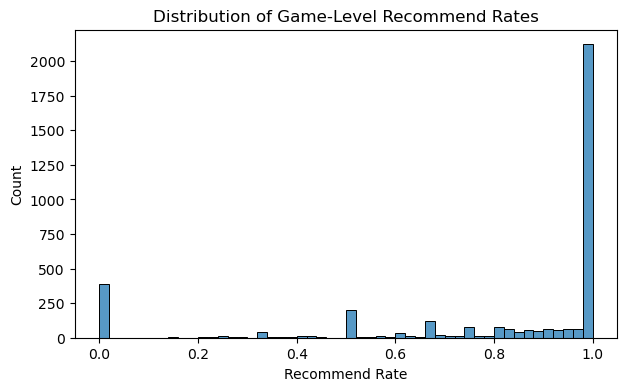

In [18]:
game_rec_rate = df_reviews.groupby('item_id')['recommend'].mean()

plt.figure(figsize=(7,4))
sns.histplot(game_rec_rate, bins=50)
plt.title("Distribution of Game-Level Recommend Rates")
plt.xlabel("Recommend Rate")
plt.show()

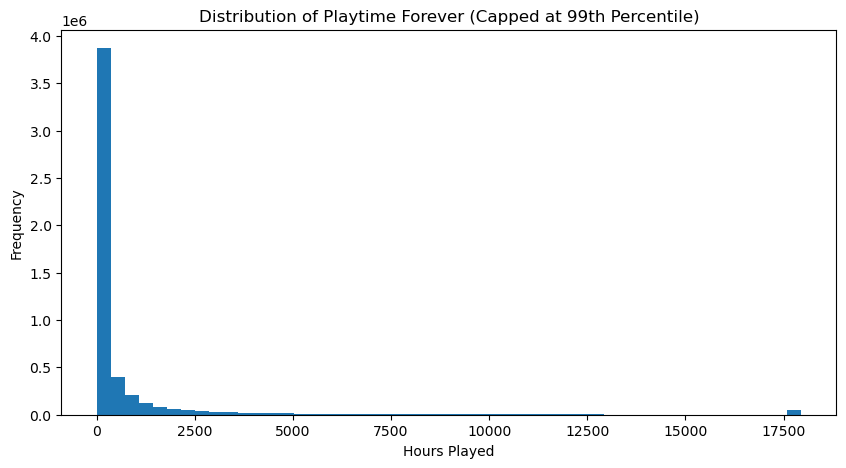

In [19]:
# Replace this with your actual DataFrame
# Example: df = df_final_australian_users_items
data = df_items["playtime_forever"]

# Remove missing values
data = data.dropna()

# Optional: cap extreme values to visualize better
# (Most playtime distributions are extremely skewed)
data_capped = np.clip(data, 0, np.percentile(data, 99))

plt.figure(figsize=(10,5))
plt.hist(data_capped, bins=50)
plt.title("Distribution of Playtime Forever (Capped at 99th Percentile)")
plt.xlabel("Hours Played")
plt.ylabel("Frequency")
plt.show()


In [ ]:
df_merged2 = df_items.merge(
    df_items[['user_id','item_id','playtime_forever','playtime_2weeks']],
    on=['user_id','item_id'],
    how='left'
)

In [20]:
df_merged = df_reviews.merge(
    df_items[['user_id','item_id','playtime_forever','playtime_2weeks']],
    on=['user_id','item_id'],
    how='left'
)

In [48]:
df_merged.shape

(60760, 12)

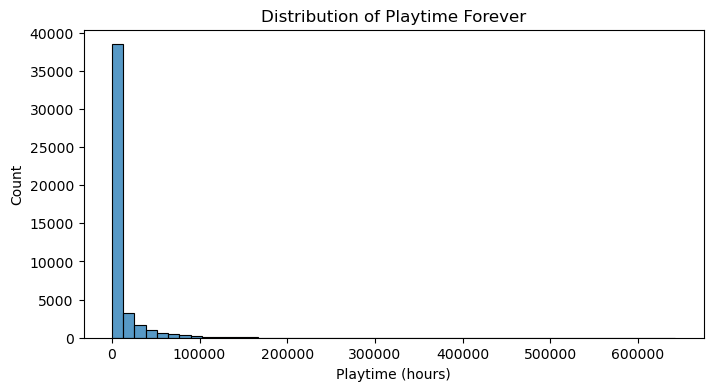

In [21]:
plt.figure(figsize=(8,4))
sns.histplot(df_merged['playtime_forever'], bins=50)
plt.title("Distribution of Playtime Forever")
plt.xlabel("Playtime (hours)")
plt.show()

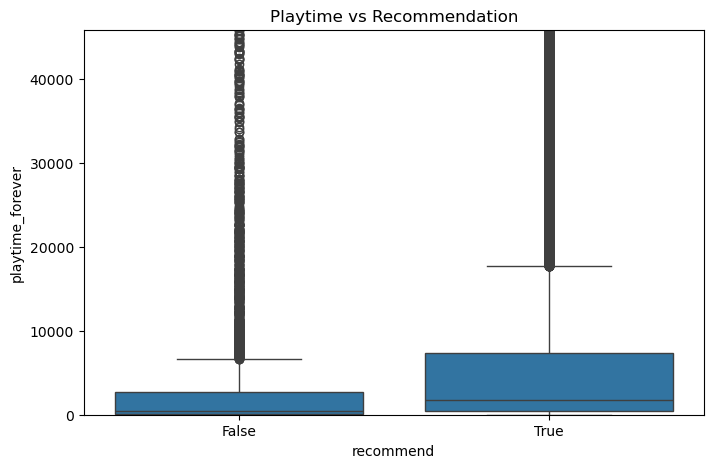

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(x='recommend', y='playtime_forever', data=df_merged)
plt.ylim(0, df_merged['playtime_forever'].quantile(0.95))  # cap outliers
plt.title("Playtime vs Recommendation")
plt.show()

In [23]:
df_full = df_merged.merge(
    df_games[['id','price','discount_price','genres','sentiment','metascore','early_access']],
    left_on='item_id', right_on='id',
    how='left'
)

df_full['price_clean'] = (
    df_full['price']
        .replace("Free to Play", "0")
        .replace("Free", "0")          # sometimes appears as "Free"
        .replace("Free To Play", "0")  # uppercase variant
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
)

df_full['price_clean'] = pd.to_numeric(df_full['price_clean'], errors='coerce')

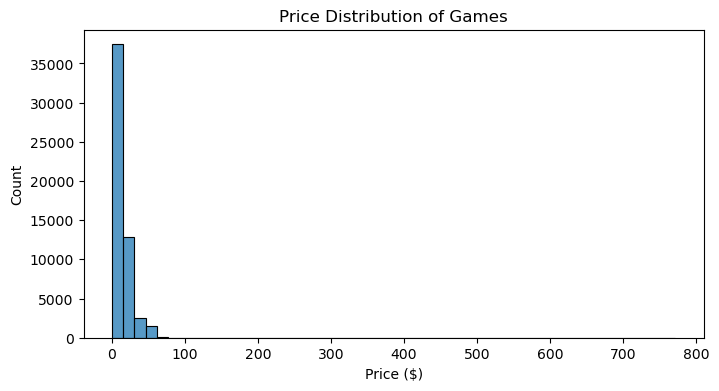

In [24]:
plt.figure(figsize=(8,4))
sns.histplot(df_full['price_clean'], bins=50)
plt.title("Price Distribution of Games")
plt.xlabel("Price ($)")
plt.show()

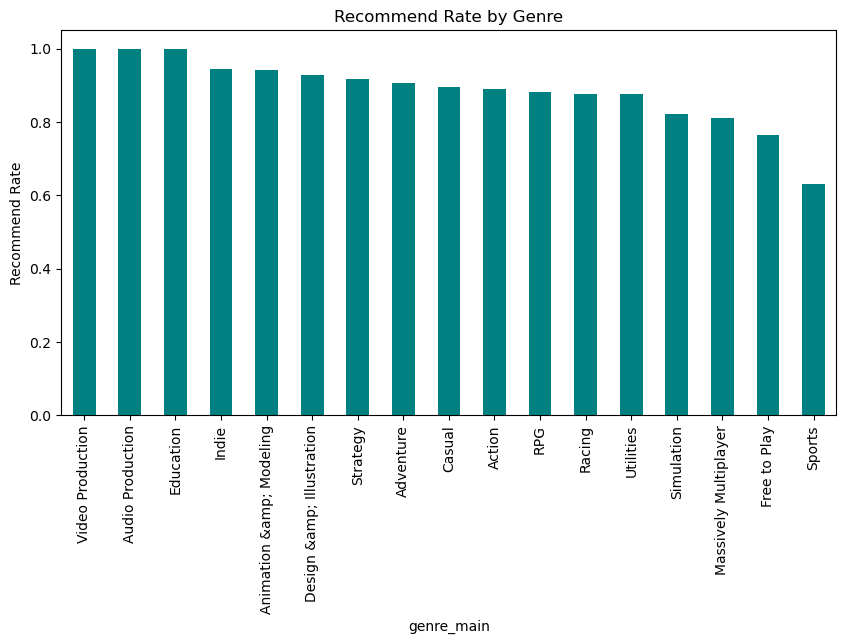

In [25]:
df_full['genre_main'] = df_full['genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x)>0 else None)

genre_rec = df_full.groupby('genre_main')['recommend'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
genre_rec.plot(kind='bar', color='teal')
plt.title("Recommend Rate by Genre")
plt.ylabel("Recommend Rate")
plt.show()

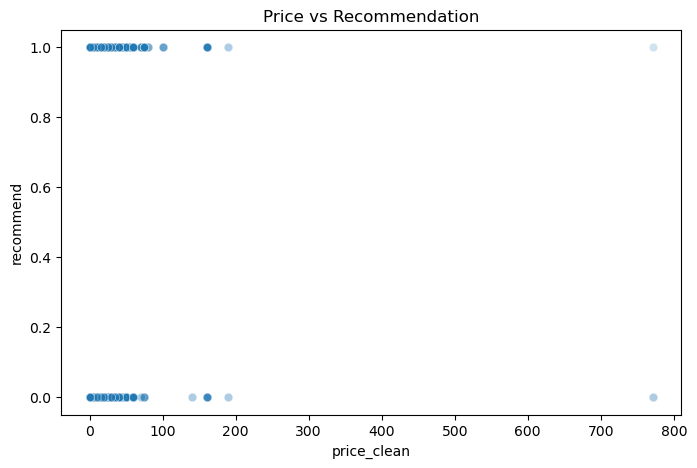

In [26]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='price_clean', y='recommend', data=df_full, alpha=0.2)
plt.title("Price vs Recommendation")
plt.show()

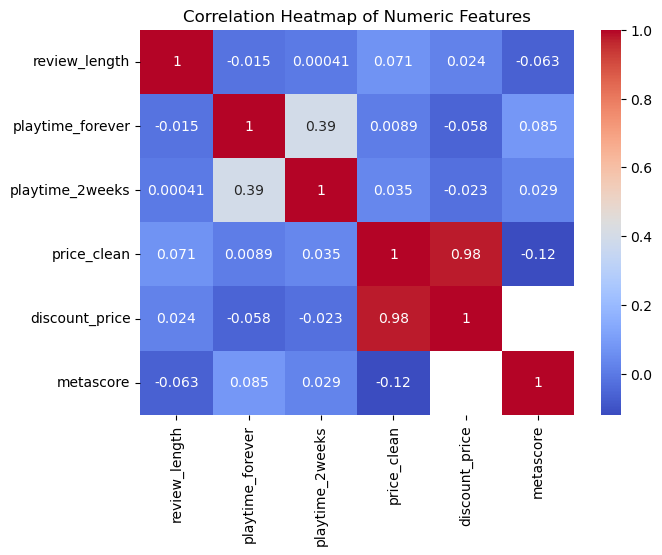

In [27]:
numeric_cols = ['review_length','playtime_forever','playtime_2weeks',
                 'price_clean','discount_price','metascore']

corr = df_full[numeric_cols].apply(pd.to_numeric, errors='coerce').corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [28]:
df_full.isnull().mean().sort_values(ascending=False)

discount_price      0.997022
metascore           0.349263
playtime_forever    0.238057
playtime_2weeks     0.238057
genres              0.149585
genre_main          0.149585
price_clean         0.103540
price               0.101418
id                  0.090742
sentiment           0.090314
early_access        0.089820
helpful             0.000921
recommend           0.000921
review              0.000921
item_id             0.000921
last_edited         0.000921
posted              0.000921
funny               0.000921
review_length       0.000000
user_url            0.000000
user_id             0.000000
dtype: float64

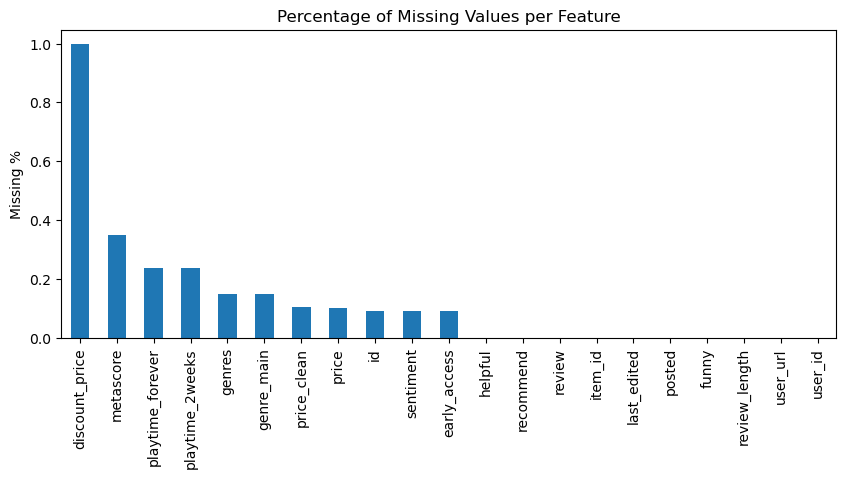

In [29]:
df_full.isnull().mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
plt.title("Percentage of Missing Values per Feature")
plt.ylabel("Missing %")
plt.show()

In [30]:
df_items.isnull().mean().sort_values(ascending=False)

item_id             0.003251
item_name           0.003251
playtime_forever    0.003251
playtime_2weeks     0.003251
user_id             0.000000
items_count         0.000000
steam_id            0.000000
user_url            0.000000
dtype: float64

In [31]:
df_reviews.isnull().mean().sort_values(ascending=False)

funny            0.000472
posted           0.000472
last_edited      0.000472
item_id          0.000472
helpful          0.000472
recommend        0.000472
review           0.000472
user_id          0.000000
user_url         0.000000
review_length    0.000000
dtype: float64

In [32]:
df_bundles.isnull().mean().sort_values(ascending=False)

bundle_final_price    0.0
bundle_url            0.0
bundle_price          0.0
bundle_name           0.0
bundle_id             0.0
bundle_discount       0.0
genre                 0.0
item_id               0.0
discounted_price      0.0
item_url              0.0
item_name             0.0
dtype: float64

In [33]:
df_games.isnull().mean().sort_values(ascending=False)

discount_price    0.992998
metascore         0.916695
publisher         0.250568
sentiment         0.223495
developer         0.102661
genres            0.102163
release_date      0.064322
title             0.063793
price             0.042850
specs             0.020850
tags              0.005072
app_name          0.000062
reviews_url       0.000062
id                0.000062
url               0.000000
early_access      0.000000
dtype: float64

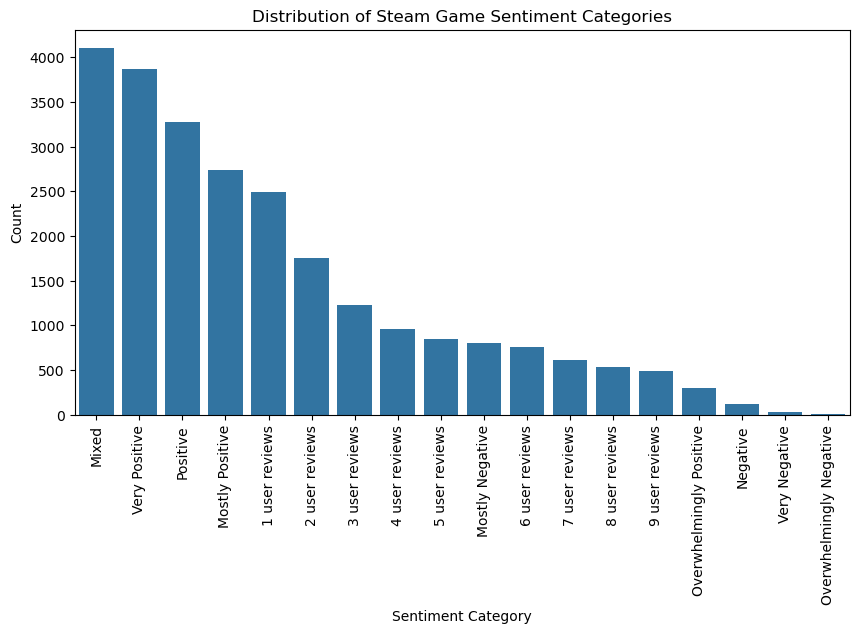

In [34]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_games, x='sentiment', order=df_games['sentiment'].value_counts().index)
plt.title("Distribution of Steam Game Sentiment Categories")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


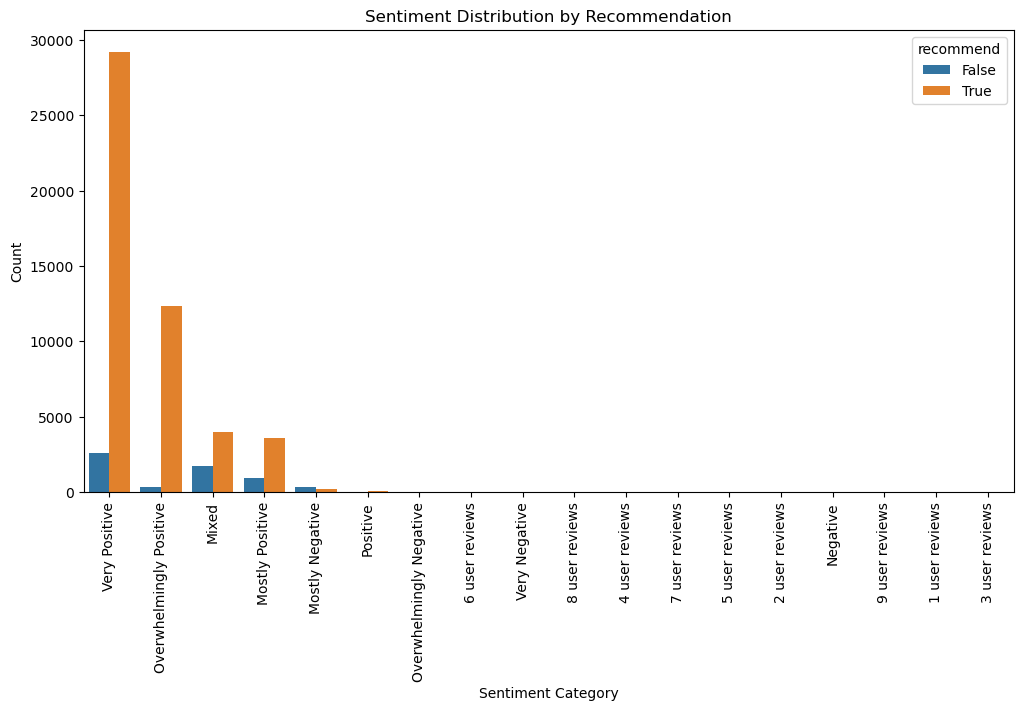

In [35]:
plt.figure(figsize=(12,6))
sns.countplot(
    data=df_full,
    x='sentiment',
    hue='recommend',
    order=df_full['sentiment'].value_counts().index
)
plt.title("Sentiment Distribution by Recommendation")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


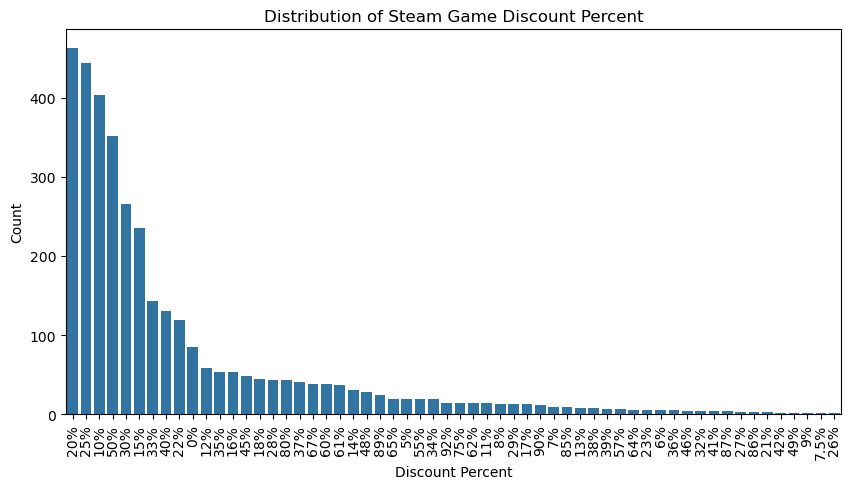

In [50]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_bundles, x='bundle_discount', order=df_bundles['bundle_discount'].value_counts().index)
plt.title("Distribution of Steam Game Discount Percent")
plt.xlabel("Discount Percent")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [37]:
df_bundles['bundle_discount'].unique()

array(['10%', '22%', '40%', '65%', '25%', '33%', '15%', '12%', '6%',
       '50%', '28%', '90%', '92%', '30%', '20%', '0%', '17%', '35%',
       '13%', '60%', '85%', '86%', '16%', '8%', '41%', '32%', '7.5%',
       '49%', '80%', '23%', '5%', '87%', '29%', '18%', '61%', '14%',
       '11%', '45%', '46%', '39%', '38%', '57%', '27%', '42%', '7%',
       '75%', '89%', '48%', '67%', '9%', '64%', '34%', '62%', '55%',
       '37%', '26%', '21%', '36%'], dtype=object)

In [38]:
# 1. Get all unique game IDs appearing in bundles
bundle_game_ids = set(df_bundles['item_id'].unique())

# 2. Add binary in_bundle feature to df_full
df_full['in_bundle'] = df_full['item_id'].apply(lambda x: 1 if x in bundle_game_ids else 0)

In [39]:
df_full['in_bundle'].value_counts()

in_bundle
0    46176
1    14612
Name: count, dtype: int64

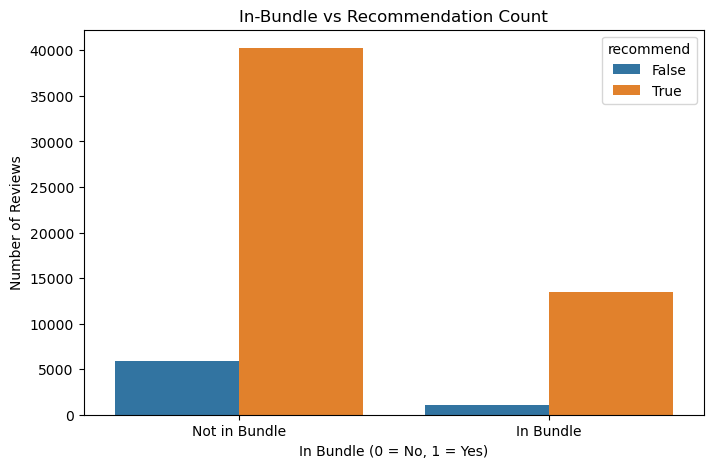

In [40]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df_full,
    x='in_bundle',
    hue='recommend'
)
plt.title("In-Bundle vs Recommendation Count")
plt.xlabel("In Bundle (0 = No, 1 = Yes)")
plt.ylabel("Number of Reviews")
plt.xticks([0,1], ["Not in Bundle", "In Bundle"])
plt.show()


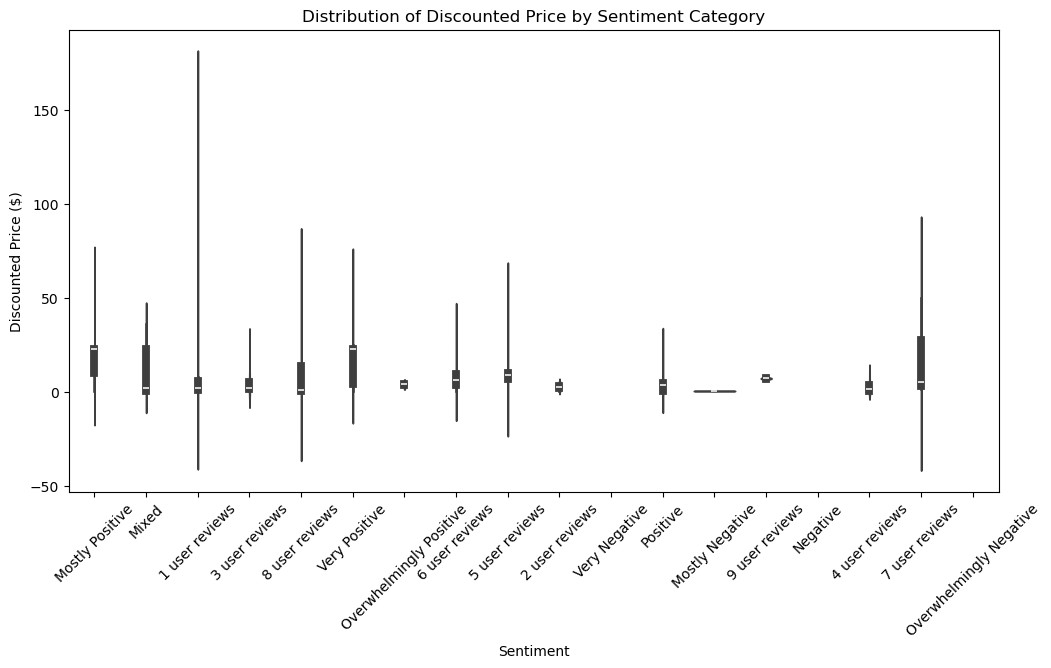

In [41]:
plt.figure(figsize=(12,6))
sns.violinplot(
    data=df_games,
    x='sentiment',
    y='discount_price'
)
plt.title("Distribution of Discounted Price by Sentiment Category")
plt.xlabel("Sentiment")
plt.ylabel("Discounted Price ($)")
plt.xticks(rotation=45)
plt.show()

In [43]:
df_full['discount_price_clean'] = (
    df_full['discount_price']
        .replace("Free to Play", "0")
        .replace("Free", "0")
        .replace("NA", np.nan)
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
)

df_full['discount_price_clean'] = pd.to_numeric(df_full['discount_price_clean'], errors='coerce')


df_full['discount_pct'] = (
    (df_full['price_clean'] - df_full['discount_price_clean']) 
    / df_full['price_clean']
).replace([np.inf, -np.inf], np.nan)


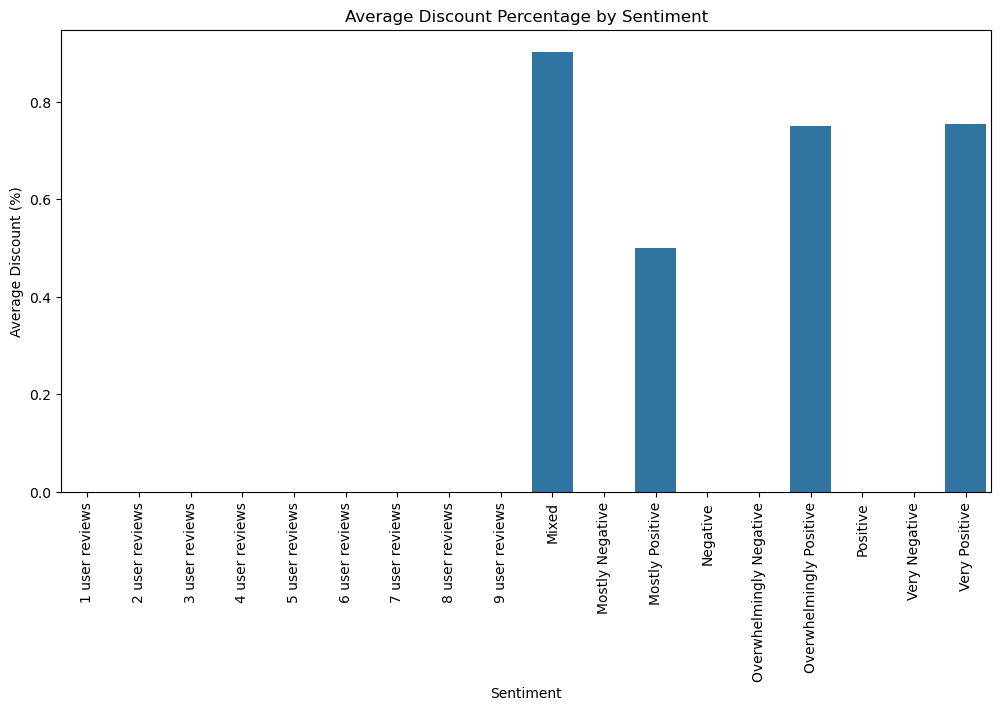

In [47]:
mean_pct = df_full.groupby('sentiment')['discount_pct'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(
    data=mean_pct,
    x='sentiment',
    y='discount_pct'
)
plt.title("Average Discount Percentage by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Discount (%)")
plt.xticks(rotation=90)
plt.show()